<a href="https://colab.research.google.com/github/piyush5566/ML_Projects/blob/master/genetic_mutation_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from collections import Counter
from scipy.sparse import hstack

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

In [0]:

data_variants = pd.read_csv('training_variants')
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [0]:
data_variants.head(3)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [0]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [0]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [0]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [0]:
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [0]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [0]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
ID      131 non-null int64
TEXT    131 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [0]:
data_text.describe()

,ID
count,131.000000
mean,59.290076
std,31.707676
min,0.000000
25%,32.500000
50%,65.000000
75%,83.500000
max,113.000000


In [0]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [0]:
data_variants.Class.unique()



array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [0]:
# Below code will take some time because its huge text (took 4 minute on my 16 GB RAM system), so run it and have a cup of coffee :)
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [0]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [0]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
131,114,MSH6,F1088Sfs*2,4,NaN
132,115,KMT2D,Deletion,1,NaN
133,116,KMT2D,Truncating Mutations,1,NaN
134,117,LATS1,Truncating Mutations,4,NaN
135,118,PBRM1,Truncating Mutations,1,NaN
...,...,...,...,...,...
3333,3316,RUNX1,D171N,4,NaN
3334,3317,RUNX1,A122*,1,NaN
3335,3318,RUNX1,Fusions,1,NaN
3336,3319,RUNX1,R80C,4,NaN


In [0]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [0]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [0]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [0]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)



In [0]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])


Number of data points in train data: 2136
Number of data points in test data: 668
Number of data points in cross validation data: 534


In [0]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()


In [0]:
train_class_distribution

1    366
2    293
3     57
4    439
5    155
6    176
7    614
8     12
9     24
Name: Class, dtype: int64

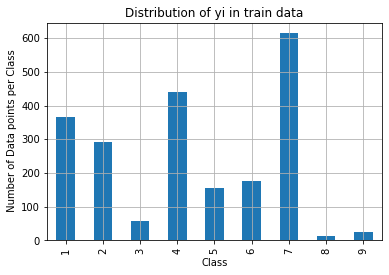

In [0]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()



In [0]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 614 ( 28.745 %)
Number of data points in class 4 : 439 ( 20.552 %)
Number of data points in class 1 : 366 ( 17.135 %)
Number of data points in class 2 : 293 ( 13.717 %)
Number of data points in class 6 : 176 ( 8.24 %)
Number of data points in class 5 : 155 ( 7.257 %)
Number of data points in class 3 : 57 ( 2.669 %)
Number of data points in class 9 : 24 ( 1.124 %)
Number of data points in class 8 : 12 ( 0.562 %)


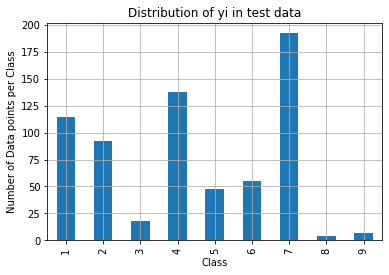

In [0]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [0]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 192 ( 28.743 %)
Number of data points in class 4 : 138 ( 20.659 %)
Number of data points in class 1 : 114 ( 17.066 %)
Number of data points in class 2 : 92 ( 13.772 %)
Number of data points in class 6 : 55 ( 8.234 %)
Number of data points in class 5 : 48 ( 7.186 %)
Number of data points in class 3 : 18 ( 2.695 %)
Number of data points in class 9 : 7 ( 1.048 %)
Number of data points in class 8 : 4 ( 0.599 %)


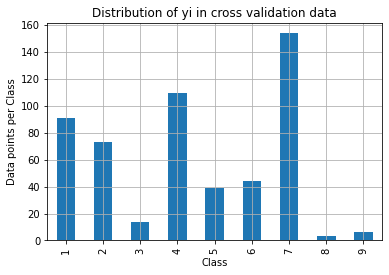

In [0]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [0]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 154 ( 28.839 %)
Number of data points in class 4 : 110 ( 20.599 %)
Number of data points in class 1 : 91 ( 17.041 %)
Number of data points in class 2 : 73 ( 13.67 %)
Number of data points in class 6 : 44 ( 8.24 %)
Number of data points in class 5 : 39 ( 7.303 %)
Number of data points in class 3 : 14 ( 2.622 %)
Number of data points in class 9 : 6 ( 1.124 %)
Number of data points in class 8 : 3 ( 0.562 %)


In [0]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [0]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.485637116952126


In [0]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.5138658074562628


In [0]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [0]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([0, 5, 8, 7, 6, 7, 3, 4, 8, 4, 6, 1, 8, 4, 3, 7, 7, 8, 8, 3, 5, 2,
       6, 8, 6, 0, 8, 1, 6, 4, 8, 2, 6, 0, 1, 0, 0, 4, 4, 3, 1, 3, 8, 3,
       6, 3, 8, 4, 6, 2, 5, 7, 0, 8, 6, 0, 2, 3, 4, 3, 5, 2, 4, 5, 4, 7,
       7, 4, 2, 4, 0, 0, 4, 2, 5, 0, 2, 6, 0, 0, 5, 1, 3, 0, 4, 3, 7, 4,
       0, 2, 0, 0, 7, 0, 4, 0, 1, 2, 7, 4, 4, 1, 4, 2, 2, 3, 4, 2, 7, 8,
       8, 0, 3, 4, 0, 0, 7, 4, 3, 5, 0, 0, 0, 4, 0, 6, 7, 3, 8, 8, 0, 3,
       3, 6, 5, 4, 6, 2, 5, 6, 6, 8, 8, 8, 6, 3, 3, 7, 6, 8, 3, 5, 8, 4,
       1, 3, 0, 8, 3, 7, 6, 2, 4, 3, 1, 6, 2, 3, 7, 7, 3, 2, 5, 1, 2, 4,
       5, 4, 5, 6, 8, 6, 4, 3, 7, 4, 7, 5, 3, 7, 7, 7, 5, 3, 0, 1, 4, 5,
       1, 0, 1, 8, 5, 1, 2, 2, 6, 8, 7, 8, 4, 0, 8, 8, 4, 8, 0, 6, 7, 1,
       0, 7, 1, 7, 6, 3, 7, 2, 0, 2, 5, 5, 2, 6, 0, 2, 5, 2, 7, 7, 3, 6,
       8, 4, 1, 1, 0, 2, 4, 4, 4, 1, 2, 0, 0, 1, 3, 8, 0, 7, 6, 1, 0, 2,
       7, 6, 7, 8, 5, 1, 3, 8, 5, 0, 3, 7, 1, 4, 1, 1, 4, 6, 5, 0, 8, 3,
       8, 7, 8, 5, 3, 7, 0, 2, 0, 4, 7, 4, 3, 1, 2,

In [0]:
predicted_y = predicted_y + 1

In [0]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 235
BRCA1     170
TP53      100
EGFR       83
PTEN       80
BRCA2      78
BRAF       71
KIT        62
ERBB2      49
ALK        47
PIK3CA     44
Name: Gene, dtype: int64


In [0]:
unique_genes.shape[0]

235

In [0]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [0]:
train_gene_feature_onehotCoding.shape

(2136, 234)

In [0]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid5b',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'b2m',
 'bap1',
 'bard1',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ikzf1',
 'inp

In [0]:





# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [0]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [0]:
train_gene_feature_responseCoding.shape

(2136, 9)

In [0]:
train_df['Gene'].head()

3298      RET
642     FBXW7
3280      RET
1441    FGFR3
533      TP53
Name: Gene, dtype: object

In [0]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [0]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.218329020915934
For values of alpha =  0.0001 The log loss is: 1.2099623129114874
For values of alpha =  0.001 The log loss is: 1.2665056681119962
For values of alpha =  0.01 The log loss is: 1.3948955290997478
For values of alpha =  0.1 The log loss is: 1.4871964876029153
For values of alpha =  1 The log loss is: 1.5259392050681313


In [0]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.218329020915934
For values of alpha =  0.0001 The log loss is: 1.2099623129114874
For values of alpha =  0.001 The log loss is: 1.2665056681119962
For values of alpha =  0.01 The log loss is: 1.3948955290997478
For values of alpha =  0.1 The log loss is: 1.4871964876029153
For values of alpha =  1 The log loss is: 1.5259392050681313


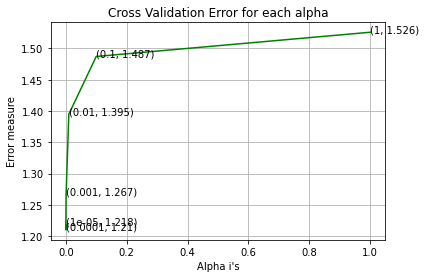

In [0]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.9850348320878805
For values of best alpha =  0.0001 The cross validation log loss is: 1.2099623129114874
For values of best alpha =  0.0001 The test log loss is: 1.1500591962154771


In [0]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [0]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)


1. In test data 646 out of 668 : 96.7065868263473
2. In cross validation data 519 out of  534 : 97.19101123595506


In [0]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1938
Truncating_Mutations    67
Amplification           44
Deletion                44
Fusions                 17
G12V                     4
Q61R                     3
G12S                     2
T58I                     2
M90I                     2
S308A                    2
Name: Variation, dtype: int64


In [0]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [0]:
train_variation_feature_onehotCoding.shape

(2136, 1972)

In [0]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [0]:
train_variation_feature_responseCoding.shape

(2136, 9)

In [0]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [0]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.684428332593489
For values of alpha =  0.0001 The log loss is: 1.6707188109789852
For values of alpha =  0.001 The log loss is: 1.6705139354052099
For values of alpha =  0.01 The log loss is: 1.6738892487111199
For values of alpha =  0.1 The log loss is: 1.6911471244197893
For values of alpha =  1 The log loss is: 1.694721353005843


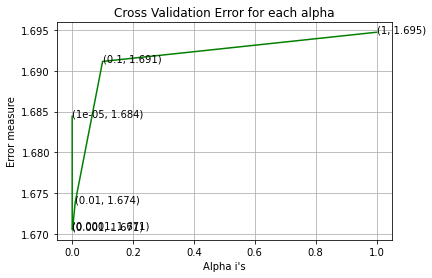

In [0]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 1.0304599636700056
For values of best alpha =  0.001 The cross validation log loss is: 1.6705139354052099
For values of best alpha =  0.001 The test log loss is: 1.7190873437811298


In [0]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [0]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 72 out of 668 : 10.778443113772456
2. In cross validation data 64 out of  534 : 11.985018726591761


In [0]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [0]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))


Total number of unique words in train data : 8081


In [0]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [0]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [0]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [0]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_text_feature_TFIDF=vectorizer.fit_transform(train_df['TEXT'])
train_text_feature_TFIDF=normalize(train_text_feature_TFIDF,axis=0)

test_text_feature_TFIDF = normalize(vectorizer.transform(test_df['TEXT']),axis=0)

cv_text_feature_TFIDF=normalize(vectorizer.transform(cv_df['TEXT']),axis=0)


In [0]:
train_df['TEXT'].tail()

68      genes encoding components pi3k akt mtor signal...
2136                                   CCND1 D289_D292del
275                                            EGFR E330K
3155                                           KRAS K147E
2069                                  MYC PVT1-MYC Fusion
Name: TEXT, dtype: object

In [0]:
from gensim.models import Word2Vec
model=Word2Vec([train_df['TEXT'].tolist()],min_count=1,size=9)
train_text_feature_word2vec= np.array([model[word[1]] for word in train_df['TEXT'].iteritems()])
model=Word2Vec([test_df['TEXT'].tolist()],min_count=1,size=9)
test_text_feature_word2vec= np.array([model[word[1]] for word in test_df['TEXT'].iteritems()])
model=Word2Vec([cv_df['TEXT'].tolist()],min_count=1,size=9)
cv_text_feature_word2vec= np.array([model[word[1]] for word in cv_df['TEXT'].iteritems()])


In [0]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [0]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({4: 899, 5: 576, 6: 512, 3: 490, 8: 337, 7: 320, 9: 262, 10: 231, 11: 223, 12: 216, 13: 161, 14: 160, 15: 152, 20: 128, 18: 127, 16: 119, 19: 97, 17: 93, 22: 91, 28: 79, 25: 79, 24: 73, 27: 71, 21: 70, 23: 69, 30: 65, 32: 57, 26: 57, 29: 50, 40: 42, 36: 42, 34: 41, 42: 38, 33: 38, 31: 38, 44: 37, 37: 36, 35: 35, 41: 34, 53: 33, 45: 31, 51: 30, 58: 28, 46: 28, 38: 28, 39: 27, 47: 26, 43: 26, 64: 25, 55: 25, 49: 25, 52: 24, 50: 24, 68: 23, 66: 22, 61: 22, 54: 22, 62: 21, 59: 21, 57: 21, 65: 20, 84: 19, 60: 19, 76: 18, 56: 18, 79: 16, 72: 16, 63: 16, 48: 16, 93: 15, 75: 15, 67: 15, 85: 14, 74: 14, 73: 14, 70: 14, 81: 13, 113: 12, 96: 12, 82: 12, 77: 12, 102: 11, 91: 11, 90: 11, 83: 11, 80: 11, 98: 10, 88: 10, 123: 9, 121: 9, 115: 9, 110: 9, 106: 9, 104: 9, 103: 9, 99: 9, 97: 9, 78: 9, 69: 9, 144: 8, 116: 8, 112: 8, 111: 8, 109: 8, 95: 8, 92: 8, 87: 8, 71: 8, 133: 7, 130: 7, 126: 7, 124: 7, 120: 7, 118: 7, 114: 7, 105: 7, 100: 7, 94: 7, 89: 7, 271: 6, 228: 6, 171: 6, 154: 6, 138: 6

In [0]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.5874883627389607
For values of alpha =  0.0001 The log loss is: 1.543508341176817
For values of alpha =  0.001 The log loss is: 1.6101722272076209
For values of alpha =  0.01 The log loss is: 1.7295340880857022
For values of alpha =  0.1 The log loss is: 1.8203349418157253
For values of alpha =  1 The log loss is: 1.8348023672838922


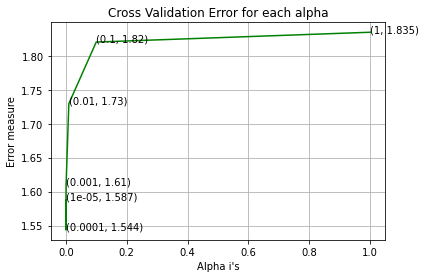

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.514299407521937
For values of best alpha =  0.0001 The cross validation log loss is: 1.543508341176817
For values of best alpha =  0.0001 The test log loss is: 1.55396657252563


In [0]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [0]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

89.551 % of word of test data appeared in train data
94.491 % of word of Cross Validation appeared in train data


In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


train_x_TFIDF = np.hstack((train_gene_var_onehotCoding.toarray(), train_text_feature_TFIDF.toarray()))
test_x_TFIDF = np.hstack((test_gene_var_onehotCoding.toarray(), test_text_feature_TFIDF.toarray()))
cv_x_TFIDF = np.hstack((cv_gene_var_onehotCoding.toarray(), cv_text_feature_TFIDF.toarray()))

#print(train_gene_var_onehotCoding.shape,train_text_feature_word2vec.shape)
train_x_word2vec = np.hstack((train_gene_var_onehotCoding.toarray(), train_text_feature_word2vec))
test_x_word2vec = np.hstack((test_gene_var_onehotCoding.toarray(), test_text_feature_word2vec))
cv_x_word2vec = np.hstack((cv_gene_var_onehotCoding.toarray(), cv_text_feature_word2vec))


In [0]:
 print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2136, 10287)
(number of data points * number of features) in test data =  (668, 10287)
(number of data points * number of features) in cross validation data = (534, 10287)


In [0]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2136, 27)
(number of data points * number of features) in test data =  (668, 27)
(number of data points * number of features) in cross validation data = (534, 27)


In [0]:
print(" TFIDF features :")
print("(number of data points * number of features) in train data = ", train_x_TFIDF.shape)
print("(number of data points * number of features) in test data = ", test_x_TFIDF.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_TFIDF.shape)

 TFIDF features :
(number of data points * number of features) in train data =  (2136, 24025)
(number of data points * number of features) in test data =  (668, 24025)
(number of data points * number of features) in cross validation data = (534, 24025)


In [0]:
print(" Word2vec features :")
print("(number of data points * number of features) in train data = ", train_x_word2vec.shape)
print("(number of data points * number of features) in test data = ", test_x_word2vec.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_word2vec.shape)

 Word2vec features :
(number of data points * number of features) in train data =  (2136, 2215)
(number of data points * number of features) in test data =  (668, 2215)
(number of data points * number of features) in cross validation data = (534, 2215)


LOGISTIC REGRESSION

In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.6009033787055125
for alpha = 1e-05
Log Loss : 1.40495778530895
for alpha = 0.0001
Log Loss : 1.2489902874921839
for alpha = 0.001
Log Loss : 1.1996735484281416
for alpha = 0.01
Log Loss : 1.3129012279139947
for alpha = 0.1
Log Loss : 1.4850754174045655
for alpha = 1
Log Loss : 1.685081736900439
for alpha = 10
Log Loss : 1.7122932271968572
for alpha = 100
Log Loss : 1.7152399418840754


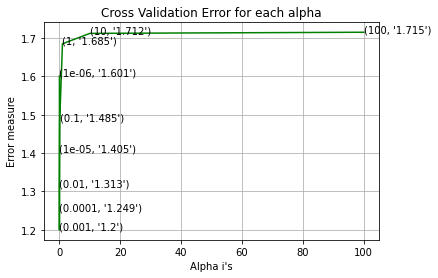

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
y_pred=clf.predict(test_x_onehotCoding)


For values of best alpha =  0.001 The train log loss is: 0.802772309843151
For values of best alpha =  0.001 The cross validation log loss is: 1.1996735484281416
For values of best alpha =  0.001 The test log loss is: 1.1241727835681752


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.63      0.57      0.60       114
           2       0.62      0.42      0.50        92
           3       0.11      0.11      0.11        18
           4       0.79      0.59      0.67       138
           5       0.32      0.46      0.38        48
           6       0.50      0.38      0.43        55
           7       0.60      0.81      0.69       192
           8       0.25      0.25      0.25         4
           9       0.75      0.86      0.80         7

    accuracy                           0.59       668
   macro avg       0.51      0.49      0.49       668
weighted avg       0.60      0.59      0.58       668



**WITH TF-IDF**

In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_TFIDF, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_TFIDF, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_TFIDF)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.5126395735921332
for alpha = 1e-05
Log Loss : 1.4390050184385195
for alpha = 0.0001
Log Loss : 1.2361624670887448
for alpha = 0.001
Log Loss : 1.1626669072291782
for alpha = 0.01
Log Loss : 1.2655802143366568
for alpha = 0.1
Log Loss : 1.3512736462156185
for alpha = 1
Log Loss : 1.43585870960751
for alpha = 10
Log Loss : 1.5189785300372525
for alpha = 100
Log Loss : 1.6338316805063828


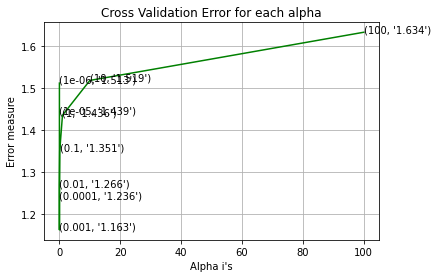

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_TFIDF, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_TFIDF, train_y)

predict_y = sig_clf.predict_proba(train_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
y_pred=clf.predict(test_x_TFIDF)


For values of best alpha =  0.001 The train log loss is: 0.6950978276544733
For values of best alpha =  0.001 The cross validation log loss is: 1.1626669072291782
For values of best alpha =  0.001 The test log loss is: 1.1129921102543454


Without balancing

In [0]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 




for alpha = 1e-06
Log Loss : 1.6591029697335815
for alpha = 1e-05
Log Loss : 1.423737844890255
for alpha = 0.0001
Log Loss : 1.209875892379961
for alpha = 0.001
Log Loss : 1.1733522532685683
for alpha = 0.01
Log Loss : 1.297210832569164
for alpha = 0.1
Log Loss : 1.4474595917633726
for alpha = 1
Log Loss : 1.6559712113770275


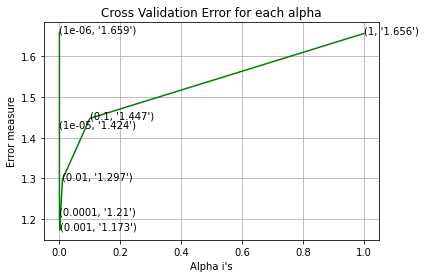

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
y_pred=clf.predict(test_x_onehotCoding
                   )

For values of best alpha =  0.001 The train log loss is: 0.7989099627790036
For values of best alpha =  0.001 The cross validation log loss is: 1.1733522532685683
For values of best alpha =  0.001 The test log loss is: 1.1146637436586488


In [0]:
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.65      0.59      0.62       114
           2       0.66      0.36      0.46        92
           3       0.00      0.00      0.00        18
           4       0.74      0.67      0.71       138
           5       0.34      0.46      0.39        48
           6       0.60      0.27      0.37        55
           7       0.58      0.90      0.70       192
           8       0.00      0.00      0.00         4
           9       0.75      0.43      0.55         7

    accuracy                           0.61       668
   macro avg       0.48      0.41      0.42       668
weighted avg       0.60      0.61      0.58       668



**WITHOUT BALANCING WITH TF-IDF**

In [0]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_TFIDF, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_TFIDF, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_TFIDF)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 




for alpha = 1e-06
Log Loss : 1.5503027742587812
for alpha = 1e-05
Log Loss : 1.4634755403052229
for alpha = 0.0001
Log Loss : 1.2228552499382683
for alpha = 0.001
Log Loss : 1.1577273657227445
for alpha = 0.01
Log Loss : 1.2518750974628239
for alpha = 0.1
Log Loss : 1.3356556710875371
for alpha = 1
Log Loss : 1.412102259726793


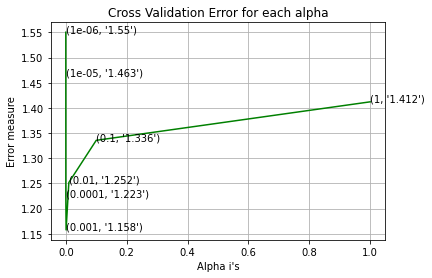

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_TFIDF, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_TFIDF, train_y)

predict_y = sig_clf.predict_proba(train_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
y_pred=clf.predict(test_x_TFIDF
                   )

For values of best alpha =  0.001 The train log loss is: 0.6804369370443727
For values of best alpha =  0.001 The cross validation log loss is: 1.1577273657227445
For values of best alpha =  0.001 The test log loss is: 1.1095181080876333


In [0]:
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.68      0.57      0.62       114
           2       0.82      0.29      0.43        92
           3       0.00      0.00      0.00        18
           4       0.77      0.71      0.74       138
           5       0.34      0.46      0.39        48
           6       0.60      0.27      0.37        55
           7       0.58      0.96      0.72       192
           8       0.00      0.00      0.00         4
           9       0.75      0.43      0.55         7

    accuracy                           0.62       668
   macro avg       0.50      0.41      0.43       668
weighted avg       0.64      0.62      0.59       668



# Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.5563683822812329
for C = 0.0001
Log Loss : 1.3047129437974174
for C = 0.001
Log Loss : 1.2999364633178778
for C = 0.01
Log Loss : 1.479078720754013
for C = 0.1
Log Loss : 1.4390277806796572
for C = 1
Log Loss : 1.7112152540779793
for C = 10
Log Loss : 1.7160878258190333
for C = 100
Log Loss : 1.7160879148628165


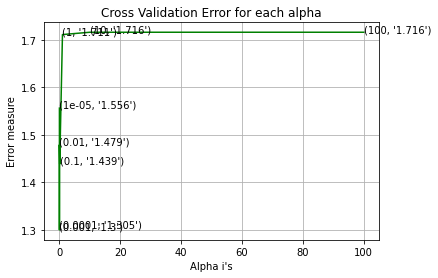

For values of best alpha =  0.001 The train log loss is: 0.7147764922421609
For values of best alpha =  0.001 The cross validation log loss is: 1.2999364633178778
For values of best alpha =  0.001 The test log loss is: 1.2967059348194367


In [0]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
y_pred=clf.predict(test_x_onehotCoding)

In [0]:
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.62      0.57      0.60       114
           2       0.55      0.49      0.52        92
           3       0.08      0.11      0.10        18
           4       0.75      0.62      0.68       138
           5       0.32      0.52      0.40        48
           6       0.50      0.38      0.43        55
           7       0.67      0.71      0.69       192
           8       0.10      0.25      0.14         4
           9       0.75      0.86      0.80         7

    accuracy                           0.58       668
   macro avg       0.48      0.50      0.48       668
weighted avg       0.60      0.58      0.59       668



**WITH TFIDF**

for C = 1e-05
Log Loss : 1.4708722468368236
for C = 0.0001
Log Loss : 1.3402674938749082
for C = 0.001
Log Loss : 1.2288246591987448
for C = 0.01
Log Loss : 1.3468234869284221
for C = 0.1
Log Loss : 1.486783902722859
for C = 1
Log Loss : 1.4936654210658082
for C = 10
Log Loss : 1.4711215493637437
for C = 100
Log Loss : 1.6970307240245672


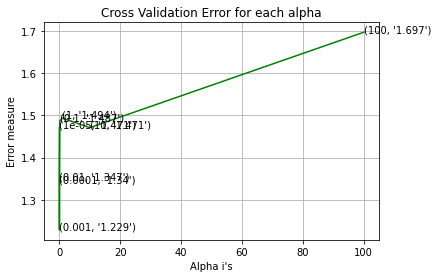

For values of best alpha =  0.001 The train log loss is: 0.4751882974687579
For values of best alpha =  0.001 The cross validation log loss is: 1.2288246591987448
For values of best alpha =  0.001 The test log loss is: 1.2126577110692782


In [0]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_TFIDF, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_TFIDF, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_TFIDF)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_TFIDF, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_TFIDF, train_y)

predict_y = sig_clf.predict_proba(train_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
y_pred=clf.predict(test_x_TFIDF)

In [0]:
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.62      0.58      0.60       114
           2       0.56      0.48      0.51        92
           3       0.11      0.11      0.11        18
           4       0.76      0.62      0.69       138
           5       0.31      0.52      0.39        48
           6       0.48      0.40      0.44        55
           7       0.65      0.73      0.69       192
           8       0.20      0.25      0.22         4
           9       0.83      0.71      0.77         7

    accuracy                           0.59       668
   macro avg       0.50      0.49      0.49       668
weighted avg       0.60      0.59      0.59       668



# Random Forest Classifier

## Model with One hot encoder

In [0]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.3950452654405427
for n_estimators = 100 and max depth =  10
Log Loss : 1.3235595204422397
for n_estimators = 200 and max depth =  5
Log Loss : 1.3983940871454952
for n_estimators = 200 and max depth =  10
Log Loss : 1.3149553664203244
for n_estimators = 500 and max depth =  5
Log Loss : 1.3773409515121684
for n_estimators = 500 and max depth =  10
Log Loss : 1.3006829917920208
for n_estimators = 1000 and max depth =  5
Log Loss : 1.3746627022321574
for n_estimators = 1000 and max depth =  10
Log Loss : 1.3015236310643052
for n_estimators = 2000 and max depth =  5
Log Loss : 1.3778195429540017
for n_estimators = 2000 and max depth =  10
Log Loss : 1.3042093824199543


In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  500 The train log loss is: 1.1102835431488984
For values of best estimator =  500 The cross validation log loss is: 1.3006829917920208
For values of best estimator =  500 The test log loss is: 1.2889518881694908


In [0]:
y_pred=clf.predict(test_x_onehotCoding)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.68      0.13      0.22       114
           2       0.83      0.05      0.10        92
           3       0.00      0.00      0.00        18
           4       0.85      0.32      0.46       138
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        55
           7       0.32      0.99      0.49       192
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.38       668
   macro avg       0.30      0.17      0.14       668
weighted avg       0.50      0.38      0.29       668



## RF with Response Coding

In [0]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.981933315744523
for n_estimators = 10 and max depth =  3
Log Loss : 1.7003157972050715
for n_estimators = 10 and max depth =  5
Log Loss : 1.4467248783612545
for n_estimators = 10 and max depth =  10
Log Loss : 1.999746082204016
for n_estimators = 50 and max depth =  2
Log Loss : 1.823640904508469
for n_estimators = 50 and max depth =  3
Log Loss : 1.4858104796965772
for n_estimators = 50 and max depth =  5
Log Loss : 1.484946096144791
for n_estimators = 50 and max depth =  10
Log Loss : 1.8887381114717499
for n_estimators = 100 and max depth =  2
Log Loss : 1.615995972770534
for n_estimators = 100 and max depth =  3
Log Loss : 1.5159821927802977
for n_estimators = 100 and max depth =  5
Log Loss : 1.4369566895625578
for n_estimators = 100 and max depth =  10
Log Loss : 1.8960847795260243
for n_estimators = 200 and max depth =  2
Log Loss : 1.6409971000835137
for n_estimators = 200 and max depth =  3
Log Loss : 1.520606721344207
for

In [0]:
y_pred=clf.predict(test_x_responseCoding)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.36      0.90      0.51       114
           2       0.56      0.20      0.29        92
           3       0.00      0.00      0.00        18
           4       0.78      0.31      0.45       138
           5       0.00      0.00      0.00        48
           6       0.20      0.02      0.03        55
           7       0.59      0.88      0.70       192
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.50       668
   macro avg       0.28      0.26      0.22       668
weighted avg       0.49      0.50      0.42       668



**RF WITH WORD2VEC**

In [0]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_word2vec, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_word2vec, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_word2vec)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_word2vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, train_y)

predict_y = sig_clf.predict_proba(train_x_word2vec)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_word2vec)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.5332922071689252
for n_estimators = 10 and max depth =  3
Log Loss : 1.4880524386873586
for n_estimators = 10 and max depth =  5
Log Loss : 1.4696555325481546
for n_estimators = 10 and max depth =  10
Log Loss : 1.4170575497615867
for n_estimators = 50 and max depth =  2
Log Loss : 1.3694594179040012
for n_estimators = 50 and max depth =  3
Log Loss : 1.3574861733823638
for n_estimators = 50 and max depth =  5
Log Loss : 1.332214273341085
for n_estimators = 50 and max depth =  10
Log Loss : 1.3147339340885131
for n_estimators = 100 and max depth =  2
Log Loss : 1.3344572689587364
for n_estimators = 100 and max depth =  3
Log Loss : 1.3121650479529192
for n_estimators = 100 and max depth =  5
Log Loss : 1.294284160105759
for n_estimators = 100 and max depth =  10
Log Loss : 1.2887607863209056
for n_estimators = 200 and max depth =  2
Log Loss : 1.3151186229500447
for n_estimators = 200 and max depth =  3
Log Loss : 1.3044281822323358

In [0]:
y_pred=clf.predict(test_x_word2vec)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.74      0.25      0.37       114
           2       1.00      0.03      0.06        92
           3       0.00      0.00      0.00        18
           4       0.68      0.35      0.46       138
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        55
           7       0.34      0.99      0.51       192
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.40       668
   macro avg       0.31      0.18      0.16       668
weighted avg       0.50      0.40      0.31       668



**RF WITH TF-IDF**

In [0]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_TFIDF, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_TFIDF, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_TFIDF)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_TFIDF, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_TFIDF, train_y)

predict_y = sig_clf.predict_proba(train_x_TFIDF)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_TFIDF)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_TFIDF)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.7484428755014376
for n_estimators = 10 and max depth =  3
Log Loss : 1.686653118339874
for n_estimators = 10 and max depth =  5
Log Loss : 1.6037622360710384
for n_estimators = 10 and max depth =  10
Log Loss : 1.4925579444631565
for n_estimators = 50 and max depth =  2
Log Loss : 1.6231335830856652
for n_estimators = 50 and max depth =  3
Log Loss : 1.5794341709637159
for n_estimators = 50 and max depth =  5
Log Loss : 1.4808679277801973
for n_estimators = 50 and max depth =  10
Log Loss : 1.37330509701392
for n_estimators = 100 and max depth =  2
Log Loss : 1.6082598468741987
for n_estimators = 100 and max depth =  3
Log Loss : 1.531871339840382
for n_estimators = 100 and max depth =  5
Log Loss : 1.440786082322403
for n_estimators = 100 and max depth =  10
Log Loss : 1.3489817617297009
for n_estimators = 200 and max depth =  2
Log Loss : 1.5995386250119012
for n_estimators = 200 and max depth =  3
Log Loss : 1.5509574979478904
fo

In [0]:
y_pred=clf.predict(test_x_TFIDF)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.78      0.12      0.21       114
           2       0.80      0.04      0.08        92
           3       0.00      0.00      0.00        18
           4       0.82      0.33      0.47       138
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        55
           7       0.32      0.98      0.48       192
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.38       668
   macro avg       0.30      0.16      0.14       668
weighted avg       0.50      0.38      0.28       668



***NAIVE BAYES***

**WITH ONEHOTCODING**

In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.3636379919304735
for alpha = 0.0001
Log Loss : 1.36009439103075
for alpha = 0.001
Log Loss : 1.3469983820465137
for alpha = 0.1
Log Loss : 1.2530486133220125
for alpha = 1
Log Loss : 1.220407646231648
for alpha = 10
Log Loss : 1.2989141588158841
for alpha = 100
Log Loss : 1.3682118533664347
for alpha = 1000
Log Loss : 1.3737957951991377


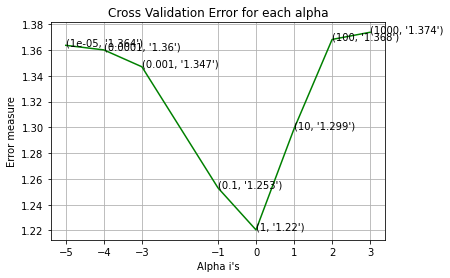

In [0]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1 The train log loss is: 0.769457631913983
For values of best alpha =  1 The cross validation log loss is: 1.220407646231648
For values of best alpha =  1 The test log loss is: 1.1995942911321664


Log Loss : 1.220407646231648
Number of missclassified point : 0.4288389513108614
-------------------- Confusion matrix --------------------


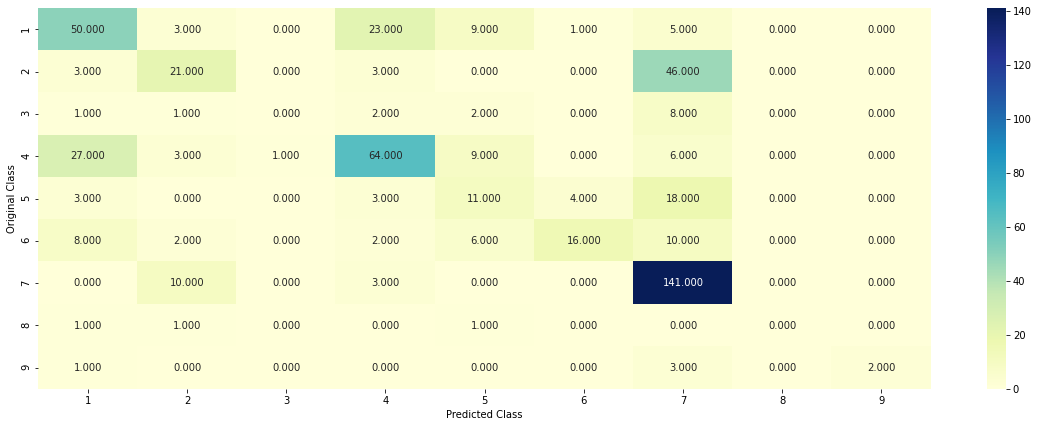

-------------------- Precision matrix (Columm Sum=1) --------------------


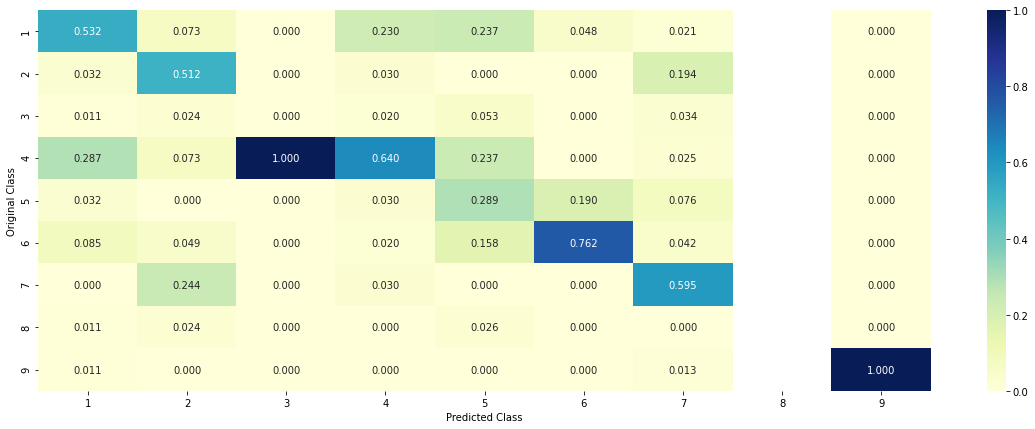

-------------------- Recall matrix (Row sum=1) --------------------


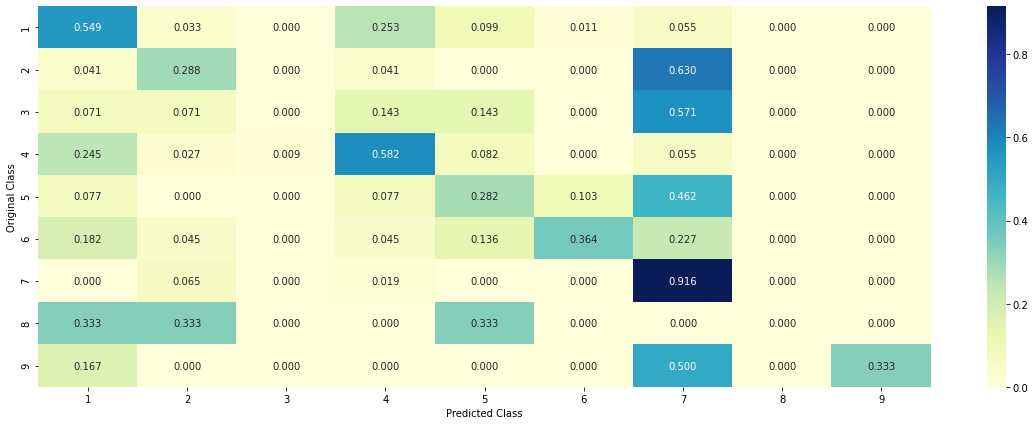

In [0]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))


In [0]:
y_pred=clf.predict(test_x_onehotCoding)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.48      0.70      0.57       114
           2       0.75      0.23      0.35        92
           3       0.00      0.00      0.00        18
           4       0.73      0.67      0.70       138
           5       0.00      0.00      0.00        48
           6       0.57      0.31      0.40        55
           7       0.59      0.95      0.73       192
           8       0.00      0.00      0.00         4
           9       0.75      0.43      0.55         7

    accuracy                           0.59       668
   macro avg       0.43      0.37      0.37       668
weighted avg       0.56      0.59      0.54       668



**WITH TF-IDF**

In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_TFIDF, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_TFIDF, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_TFIDF)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.422984227911748
for alpha = 0.0001
Log Loss : 1.4019067596980306
for alpha = 0.001
Log Loss : 1.4051659654169408
for alpha = 0.1
Log Loss : 1.2934943042048272
for alpha = 1
Log Loss : 1.2373469856915629
for alpha = 10
Log Loss : 1.2896242080493268
for alpha = 100
Log Loss : 1.3767747361056546
for alpha = 1000
Log Loss : 1.3768082320768633


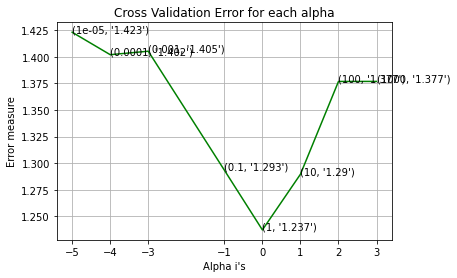

In [0]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_TFIDF, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_TFIDF, train_y)


predict_y = sig_clf.predict_proba(train_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_TFIDF)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1 The train log loss is: 0.6458532691821676
For values of best alpha =  1 The cross validation log loss is: 1.2373469856915629
For values of best alpha =  1 The test log loss is: 1.1970683190501479


In [0]:
y_pred=clf.predict(test_x_TFIDF)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.48      0.68      0.56       114
           2       0.78      0.27      0.40        92
           3       0.00      0.00      0.00        18
           4       0.73      0.69      0.71       138
           5       0.00      0.00      0.00        48
           6       0.57      0.31      0.40        55
           7       0.60      0.95      0.74       192
           8       0.00      0.00      0.00         4
           9       0.75      0.43      0.55         7

    accuracy                           0.60       668
   macro avg       0.43      0.37      0.37       668
weighted avg       0.57      0.60      0.55       668



# K Nearest Neighbour Classification

WITH RESPONSECODING

In [0]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 2.144760772758315
for alpha = 11
Log Loss : 1.7923184862099562
for alpha = 15
Log Loss : 1.641151466632089
for alpha = 21
Log Loss : 1.5696735912159838
for alpha = 31
Log Loss : 1.3912302819175855
for alpha = 41
Log Loss : 1.256927327067265
for alpha = 51
Log Loss : 1.2202927195080764
for alpha = 99
Log Loss : 1.162442935360557


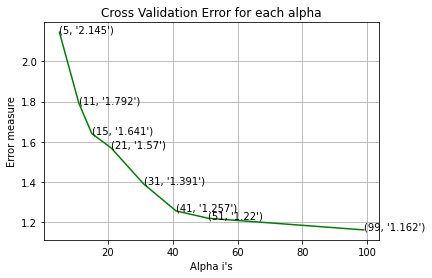

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  99 The train log loss is: 0.9317662558058032
For values of best alpha =  99 The cross validation log loss is: 1.162442935360557
For values of best alpha =  99 The test log loss is: 1.1073379210241359


Log loss : 1.162442935360557
Number of mis-classified points : 0.4232209737827715
-------------------- Confusion matrix --------------------


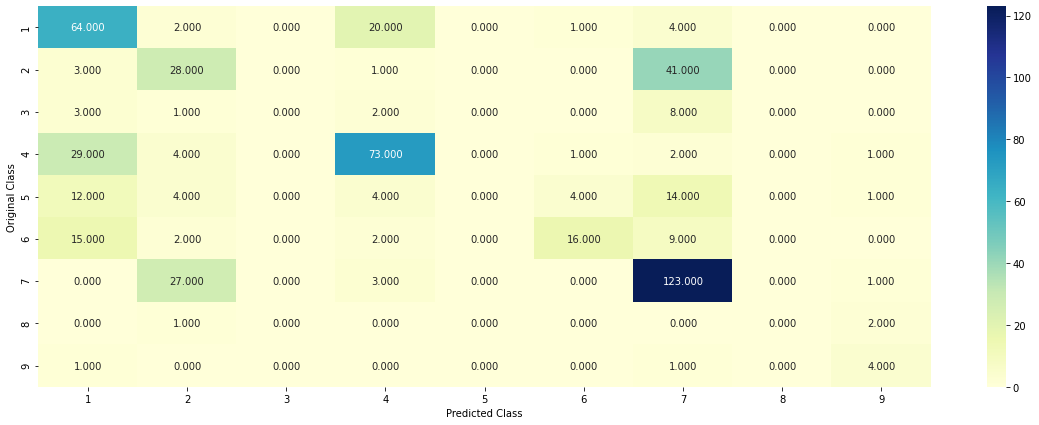

-------------------- Precision matrix (Columm Sum=1) --------------------


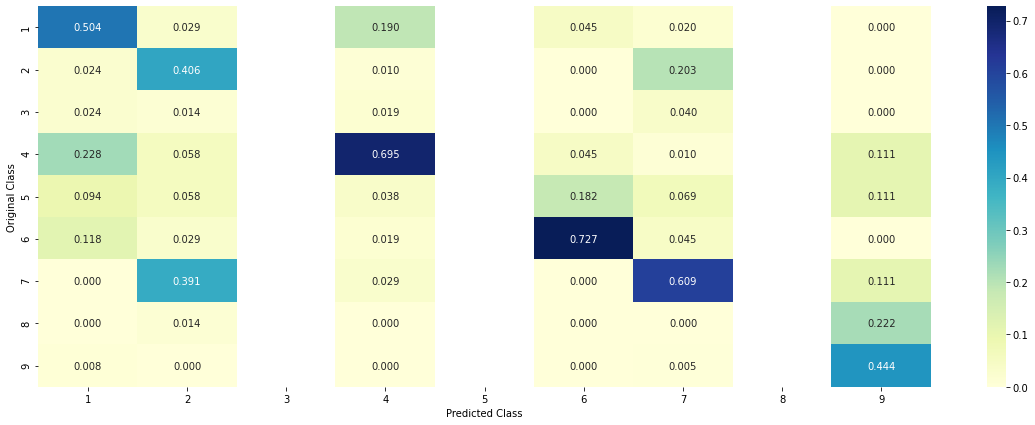

-------------------- Recall matrix (Row sum=1) --------------------


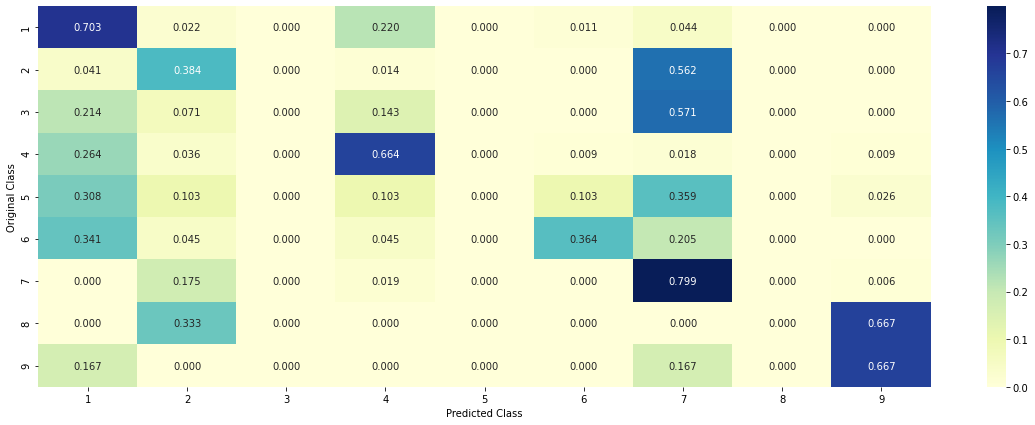

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [0]:
y_pred=clf.predict(test_x_responseCoding)
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.61      0.61      0.61       114
           2       0.67      0.24      0.35        92
           3       0.00      0.00      0.00        18
           4       0.67      0.69      0.68       138
           5       0.00      0.00      0.00        48
           6       0.35      0.55      0.43        55
           7       0.60      0.91      0.72       192
           8       0.00      0.00      0.00         4
           9       0.75      0.43      0.55         7

    accuracy                           0.59       668
   macro avg       0.41      0.38      0.37       668
weighted avg       0.54      0.59      0.54       668

